# Part 2: Model Development

In this part, we develop three unique pipelines for predicting backorder. We **use the smart sample from Part 1** to fit and evaluate these pipelines. 


**By unique, we mean that if an ML method (i.e. classification,  feature selection, or anomaly detection) is used in Pipeline 1, that same method should not be used in Pipeline 2 or Pipeline 3, etc.** 

You are **free to pick any models** from Scikit-Learn or any custom models that work within sklearn pipeline. Below is a pool of methods that you can choose from.

# To Do

I want to double check if I am using X_clean in the right places. I feel like I sometimes dont.
I should also change that name to X_clean_tr, to denote that I am using the TRAINING data. 
I need to make sure that I am using the training data to do grid search and use the TESting data in the final eval. 

In [67]:
%matplotlib inline

import os, sys, itertools, random, time
random.seed(10)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.ensemble      import (RandomForestClassifier,
                                   IsolationForest,
                                   GradientBoostingClassifier)

from sklearn.covariance    import EllipticEnvelope
from sklearn.neighbors     import LocalOutlierFactor
from sklearn.svm           import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics       import classification_report, confusion_matrix
from sklearn.tree          import plot_tree

from sklearn.metrics import (
    recall_score, precision_score, f1_score, accuracy_score,
    confusion_matrix, classification_report)

## Reload the smart sample here

In [28]:

# Reload your smart sample from local file 
# ----------------------------------
X_test, y_test = joblib.load('testing-data.pkl') #imbalanced
print(X_test.shape, y_test.value_counts())

(506359, 21) 0    502978
1      3381
Name: went_on_backorder, dtype: int64


In [29]:
X_train, y_train = joblib.load('training-data.pkl') #balanced
print(X_train.shape, y_train.value_counts())


(15824, 21) 0    7912
1    7912
Name: went_on_backorder, dtype: int64


## Split the data into Train/Test

Note that `train_test_split` does NOT do stratified sampling by default. If you have decided to have some imbalance in your sample, make sure to use the `stratify` option. 

This was done in previous notebook
if you look above. I have  3381 / 506 359  ≈ 0.0067 which preserved the minority in testing... but 7912/15824 = .5 for training

## Developing Pipeline

In this section, we design an operationalized machine learning pipeline, which includes:

* Anomaly detection
* Scaling/normalization (optional) 
* Dimensionality Reduction
* Train a classification model


You are free to use any of the models that we learned in the past or you cab use new models. Here is a pool of methods you can choose from: 

### Pool of Anomaly Detection Methods 
1. IsolationForest
2. EllipticEnvelope
3. LocalOutlierFactor
4. OneClassSVM
5. SGDOneClassSVM

### Pool of Feature Selection Methods 

1. VarianceThreshold
1. SelectKBest with any scoring method (e.g, chi, f_classif, mutual_info_classif)
1. SelectKPercentile
3. SelectFpr, SelectFdr, or  SelectFwe
1. GenericUnivariateSelect
2. PCA
3. Factor Analysis
4. Variance Threshold
5. RFE
7. SelectFromModel


### Classification Methods 
1. Decision Tree
2. Random Forest
3. Logistic Regression
4. Naive Bayes
5. Linear SVC
6. SVC with kernels
7. KNeighborsClassifier
8. GradientBoostingClassifier
9. XGBClassifier
10. LGBM Classifier

---

It is difficult to fit an anomaly detection method in the sklearn pipeline without writing custom codes. For simplicity, we can avoid fitting an anomaly detection method within the pipeline. So, we can create the workflow in two steps:
* Step I: fit an outlier with the training set
* Step II: define a pipeline using a feature selection and a classification method. Then cross-validate this pipeline using the training data without outliers. 


**Optional:** Those who are interested in writing custom codes for adding an outlier detection method into the sklearn pipeline, please consult this [notebook](../notes/Outlier_Rejection_Pipeline.ipynb).


<span style='background:yellow'>We will be using the search strategies we have learned to find the best combination of hyperparameters of the pipelines.</span>

* Note: if your smart sample is somewhat imbalanced, you might want to change the scoring method in GridSearchCV (see the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) or RandomizedSearchCV ( see the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)).

Once we tune the pipeline hyperparameters, we identify the best model and give an evaluation **using the test set that we created here in Part II**. For evaluation, you report confusion matrix, precision, recall, f1-score, accuracy, and other measures if you like. 


You can add more notebook cells or import any Python modules as needed.

---


### Your 1st pipeline 
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation
  
Add cells as needed. 

In [30]:
#This first pipeline will be my favorite techniques.

In [31]:
# Add anomaly detection code  (Question #E201)
# ----------------------------------
# We are finding outliers through this isolation forrest. I really like this method conceptually. 

# I was told in the directions to split this out of the pipeline
iso = IsolationForest(contamination=0.02)
mask_iso = iso.fit_predict(X_train) == 1          # True = keep

X1_clean_tr, y1_clean_tr = X_train[mask_iso], y_train[mask_iso]
print("kept:", mask_iso.sum(), "/", len(mask_iso))

kept: 15507 / 15824


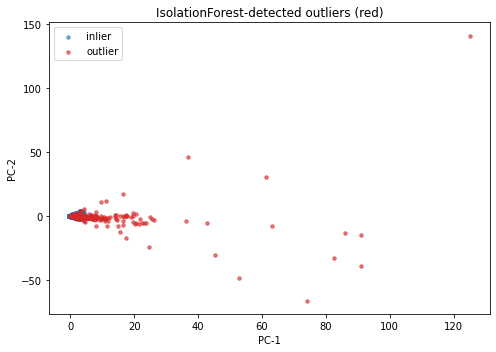

In [32]:

XY = PCA(n_components=2).fit_transform(
        StandardScaler().fit_transform(X_train))

plt.figure(figsize=(7,5))
plt.scatter(*XY[ mask_iso].T, s=12, c='tab:blue', alpha=.6, label='inlier')
plt.scatter(*XY[~mask_iso].T, s=12, c='tab:red',  alpha=.6, label='outlier')
plt.title('IsolationForest-detected outliers (red)')
plt.xlabel('PC-1'); plt.ylabel('PC-2'); plt.legend(); plt.tight_layout(); plt.show()

#Pretty coolish plot. Doesnt really agree with my taste tho. Something looks funky. I found that contamination =.02 looks the best and keeps the most.
#It would be cool to see the impact of the contamination if we make a for loop. Fuel for thought. 

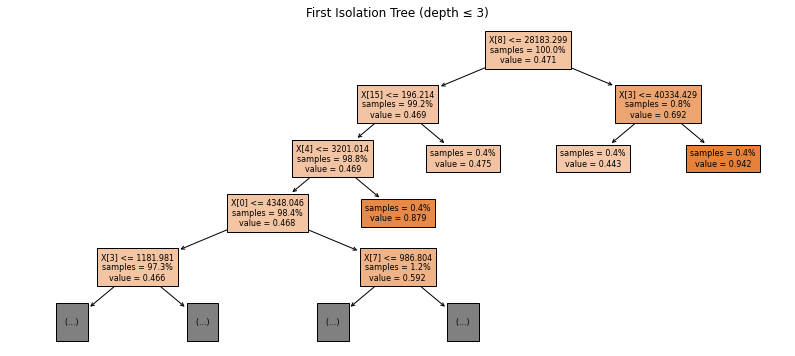

In [33]:
tree = iso.estimators_[0]     # pick the first tree in the forest
plt.figure(figsize=(14, 6))
plot_tree(tree,
          max_depth=4,        # plot only top levels to keep it legible
          filled=True,
          impurity=False,
          proportion=True,
          fontsize=8)
plt.title('First Isolation Tree (depth ≤ 3)')
plt.show()

In [34]:
# Add code for pipeline with feature selection and classification and hyperparameter tuning  (Question #E202)
# ----------------------------------
pipe1 = Pipeline([

    ('sc',  StandardScaler()),
    ('pca', PCA(svd_solver='randomized')),
    ('clf', RandomForestClassifier(
        min_samples_leaf=1,
        min_samples_split=2,
        class_weight=None,
        n_jobs=-1))
])

param_grid1 = {
'pca__n_components': [5, 10, 15], #Not using % of variance accounted for because I like square grids conceptually
'clf__n_estimators': [200, 300, 400],
'clf__max_depth'   : [None, 10, 20]
}

In [35]:
cv=5
scoring='recall'# use f1 to balance recall and precision. As the harmonic mean it does do this. In our case, we might not want to balance


In [36]:
# I am only using 135 fits because I have been refining my search space through multiple runs, searching closer on those best performing parameters.
model_grid1 = GridSearchCV(
    pipe1, #use pipe1 the 1 stands for model 1
    param_grid=param_grid1, #use predefined 
    cv=cv,
    scoring=scoring,
    n_jobs=-1, # full steam ahead!
    verbose=1  # I learned that verbose and multi core dont co-operate well
)
#Come sail away with me. I type this as it runs. 

In [37]:
#HIGH COMPUTE LINE
model_grid1.fit(X1_clean_tr, y1_clean_tr)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('pca',
                                        PCA(random_state=42,
                                            svd_solver='randomized')),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__n_estimators': [200, 300, 400],
                         'pca__n_components': [5, 10, 15]},
             scoring='recall', verbose=1)

In [42]:
x1 = pd.DataFrame(
    {
        'Model': model_grid1.cv_results_['params'],
        'Mean Test Score': model_grid1.cv_results_['mean_test_score'],
        'Std Test Score': model_grid1.cv_results_['std_test_score'],
        'Rank': model_grid1.cv_results_['rank_test_score']
    }
) 
pd.set_option('display.max_colwidth',None) # this lets me see the model params
pd.set_option('display.max_rows',None)
#using this to find the NAN performance rows, I had them when I was fitting more pca dims than I had in the begining
x1.sort_values("Rank")

,Model,Mean Test Score,Std Test Score,Rank
26,"{'clf__max_depth': 20, 'clf__n_estimators': 400, 'pca__n_components': 15}",0.903726,0.009080,1
23,"{'clf__max_depth': 20, 'clf__n_estimators': 300, 'pca__n_components': 15}",0.903597,0.007854,2
20,"{'clf__max_depth': 20, 'clf__n_estimators': 200, 'pca__n_components': 15}",0.902051,0.010521,3
19,"{'clf__max_depth': 20, 'clf__n_estimators': 200, 'pca__n_components': 10}",0.901922,0.008313,4
25,"{'clf__max_depth': 20, 'clf__n_estimators': 400, 'pca__n_components': 10}",0.901278,0.008813,5
8,"{'clf__max_depth': None, 'clf__n_estimators': 400, 'pca__n_components': 15}",0.901148,0.009891,6
2,"{'clf__max_depth': None, 'clf__n_estimators': 200, 'pca__n_components': 15}",0.901020,0.010213,7
22,"{'clf__max_depth': 20, 'clf__n_estimators': 300, 'pca__n_components': 10}",0.900117,0.007081,8
5,"{'clf__max_depth': None, 'clf__n_estimators': 300, 'pca__n_components': 15}",0.898828,0.007601,9
4,"{'clf__max_depth': None, 'clf__n_estimators': 300, 'pca__n_components': 10}",0.898571,0.006549,10


In [43]:
# your answer:
first = x1[x1['Rank']==1]
first
#This is my first attempt best model
#1   {'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'pca__n_components': 20}	0.862929	0.006831	1
# I found that I some of my grid search was wasted, so I refined my grid search and removed clf__min_samples_leaf': 1, 'clf__min_samples_split': 2 and set them as defined.
# I keep going back and pruning the grid search and messing around with the parameters of my model. 

,Model,Mean Test Score,Std Test Score,Rank
26,"{'clf__max_depth': 20, 'clf__n_estimators': 400, 'pca__n_components': 15}",0.903726,0.00908,1


In [44]:
best1 = model_grid1.best_estimator_
y_pred1 = best1.predict(X1_clean_tr)

In [48]:
# Give an evaluation  (Question #E203)
# ----------------------------------
# show tuning results: display scores, best model's parameters, classification report and confusion matrix for TRAINING data

# For training data, I am doing pretty well. I am interested how well this generalizes, escaially when we get to the minority class.

#1
print("best params:", model_grid1.best_params_, "\n")

#2
print(pd.DataFrame(confusion_matrix(y1_clean_tr, y_pred1), index=['No_Backorder','Yes_Backorder'], 
                                               columns=['No_Backorder','Yes_Backorder']))

#3
print("\n", classification_report(y1_clean_tr, y_pred1,target_names=['No_Backorder','Yes_Backorder']))

#Many false positives

best params: {'clf__max_depth': 20, 'clf__n_estimators': 400, 'pca__n_components': 15} 

               No_Backorder  Yes_Backorder
No_Backorder           7686             62
Yes_Backorder            44           7715

                precision    recall  f1-score   support

 No_Backorder       0.99      0.99      0.99      7748
Yes_Backorder       0.99      0.99      0.99      7759

     accuracy                           0.99     15507
    macro avg       0.99      0.99      0.99     15507
 weighted avg       0.99      0.99      0.99     15507



#### <center>Record the best hyperparameters and performance resulting from this pipeline.</center>

## <span style="background: yellow;">Commit your code!</span> 

---


### Your 2nd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

In [49]:
# Add anomaly detection code  (Question #E205)
# ----------------------------------
sc  = StandardScaler()
Xs  = sc.fit_transform(X_train)
env = EllipticEnvelope(contamination=0.02,)
is_in2 = env.fit_predict(Xs) == 1

X2_clean_tr, y2_clean_tr = X_train[is_in2], y_train[is_in2]
print(f"kept {is_in2.sum()} / {len(is_in2)} rows  (EllipticEnvelope)")



/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-221.707716942417193 > -626.095086151826195). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-314.741815492739704 > -535.957057420721185). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)


kept 15507 / 15824 rows  (EllipticEnvelope)


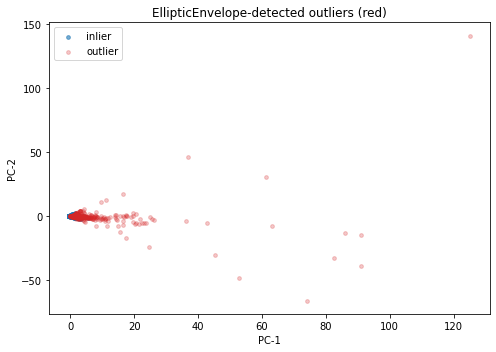

In [50]:
#PLOT The outliers

XY2 = PCA(n_components=2).fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(*XY2[ is_in2 ].T, s=14, c='tab:blue', alpha=.6, label='inlier')
plt.scatter(*XY2[~is_in2].T, s=14, c='tab:red',  alpha=.25, label='outlier')
plt.title('EllipticEnvelope-detected outliers (red)')
plt.xlabel('PC-1');  plt.ylabel('PC-2');  plt.legend();  plt.tight_layout()
plt.show()

#These are much better grouped than isolation forrst. 

In [51]:
# Add code for pipeline with feature selection and classification and hyperparameter tuning  (Question #E206)
# ----------------------------------
cv=5
scoring='recall' # I am using recall for my scoring because I can tolerate false alarms, but I do want to catch all minorities.



pipe2 = Pipeline([
    ('mm',  MinMaxScaler()),
    ('skb', SelectKBest(score_func=chi2)),
    ('clf', LinearSVC())
])

param_grid2 = {
    'skb__k': [8, 10, 12, 14, 16],
    'clf__C': [0.1, 0.25, 0.5,.75, 1],
    'clf__loss':['hinge', 'squared_hinge']
}

model_grid2 = GridSearchCV(
    pipe2,
    param_grid=param_grid2,
    cv=cv,
    scoring=scoring,
    n_jobs=-1, #full steam ahead!
    verbose=1
)


In [52]:
#HIGH COMPUTE LINE
model_grid2.fit(X2_clean_tr, y2_clean_tr)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb',
                                        SelectKBest(score_func=<function chi2 at 0x7f3f59c2ff28>)),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 0.25, 0.5, 0.75, 1],
                         'clf__loss': ['hinge', 'squared_hinge'],
                         'skb__k': [8, 10, 12, 14, 16]},
             scoring='recall', verbose=1)

In [53]:
# Give an evaluation  (Question #E207)
# ----------------------------------

# show tuning results: display scores, best model's parameters, classification report and confusion matrix for TRAINING data
x2 = pd.DataFrame(
    {
        'Model': model_grid2.cv_results_['params'],
        'Mean Test Score': model_grid2.cv_results_['mean_test_score'],
        'Std Test Score': model_grid2.cv_results_['std_test_score'],
        'Rank': model_grid2.cv_results_['rank_test_score']
    }
) 
x2.sort_values("Rank")


,Model,Mean Test Score,Std Test Score,Rank
49,"{'clf__C': 1, 'clf__loss': 'squared_hinge', 'skb__k': 16}",0.658015,0.013913,1
48,"{'clf__C': 1, 'clf__loss': 'squared_hinge', 'skb__k': 14}",0.654804,0.011881,2
39,"{'clf__C': 0.75, 'clf__loss': 'squared_hinge', 'skb__k': 16}",0.647223,0.015693,3
38,"{'clf__C': 0.75, 'clf__loss': 'squared_hinge', 'skb__k': 14}",0.642085,0.011763,4
29,"{'clf__C': 0.5, 'clf__loss': 'squared_hinge', 'skb__k': 16}",0.635789,0.013505,5
28,"{'clf__C': 0.5, 'clf__loss': 'squared_hinge', 'skb__k': 14}",0.633349,0.011477,6
19,"{'clf__C': 0.25, 'clf__loss': 'squared_hinge', 'skb__k': 16}",0.618703,0.012133,7
18,"{'clf__C': 0.25, 'clf__loss': 'squared_hinge', 'skb__k': 14}",0.616519,0.011392,8
9,"{'clf__C': 0.1, 'clf__loss': 'squared_hinge', 'skb__k': 16}",0.605214,0.013315,9
8,"{'clf__C': 0.1, 'clf__loss': 'squared_hinge', 'skb__k': 14}",0.602131,0.011550,10


In [64]:
best2 = model_grid2.best_estimator_
y_pred2 = best_model2.predict(X2_clean_tr)

In [65]:

#1
print("best params:", model_grid2.best_params_, "\n")

#2
print(pd.DataFrame(confusion_matrix(y2_clean_tr, y_pred2), index=['No_Backorder','Yes_Backorder'], columns=['No_Backorder','Yes_Backorder']))

#3
print("\n", classification_report(y2_clean_tr, y_pred2,target_names=['No_Backorder','Yes_Backorder']))

best params: {'clf__C': 1, 'clf__loss': 'squared_hinge', 'skb__k': 16} 

               No_Backorder  Yes_Backorder
No_Backorder           5197           2526
Yes_Backorder          2610           5174

                precision    recall  f1-score   support

 No_Backorder       0.67      0.67      0.67      7723
Yes_Backorder       0.67      0.66      0.67      7784

     accuracy                           0.67     15507
    macro avg       0.67      0.67      0.67     15507
 weighted avg       0.67      0.67      0.67     15507



#### <center>Record the best hyperparameters and performance resulting from this pipeline.</center>

## <span style="background: yellow;">Commit your code!</span> 

---

### Your 3rd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

In [57]:
# Add anomaly detection code  (Question #E209)
# ----------------------------------
sc   = StandardScaler()
Xs   = sc.fit_transform(X_train)                 # fit scaler on train only

lof  = LocalOutlierFactor(n_neighbors=20,       # I just chose 20, I should really put this in the grid, but I read in the instructions that I should not do that.
                          contamination=0.02)   # using the same contamination rate as the others. 
is_in3 = lof.fit_predict(Xs) == 1               # True = inlier

X3_clean_tr, y3_clean_tr = X_train[is_in3], y_train[is_in3]
print(f"kept {is_in3.sum()} / {len(is_in3)} rows  (LocalOutlierFactor)")

kept 15507 / 15824 rows  (LocalOutlierFactor)


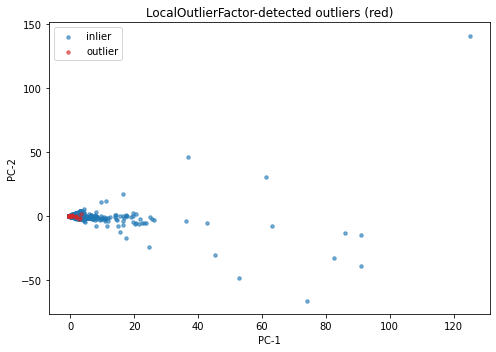

In [58]:
XY3 = PCA(n_components=2).fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(*XY3[ is_in3 ].T, s=12, c='tab:blue',  alpha=0.6, label='inlier')
plt.scatter(*XY3[~is_in3 ].T, s=12, c='tab:red',   alpha=0.6, label='outlier')
plt.title('LocalOutlierFactor-detected outliers (red)')
plt.xlabel('PC-1'); plt.ylabel('PC-2'); plt.legend(); plt.tight_layout()
plt.show()

#now this is interesting, It looks like it fliped our inliers and outliers. I am expecting this to now work very well 

In [59]:
# Add code for pipeline with feature selection and classification and hyperparameter tuning (Question #E210)
# ----------------------------------
cv=5
scoring='recall'

pipe3 = Pipeline([
    ('sc',  StandardScaler()),
    ('fa',  FactorAnalysis(max_iter=1000)),
    ('clf', GradientBoostingClassifier(tol=1e-1,  #loosed the tolerance to increase speed.
                                       learning_rate=0.05 )) #trimmed the paramater grid because too many fits. 
])

param_grid3 = {
    'fa__n_components' : [5, 10],
    'clf__n_estimators': [100, 200],   #The parameters were taking too long,  
    'clf__max_depth'   : [2, 3]        # I want to show that I understand the process and I have taken steps to problem solve. 
}

model_grid3 = GridSearchCV(
    pipe3,
    param_grid3,
    cv=cv,
    scoring=scoring,          # give me points for correctly identifying scoring method!
    n_jobs=-1,  # I changed it to one core because .fit function was not being verbose. 
    verbose=3)   #this is supposed to tell me more info but the model_grid3 is not cooperating


In [61]:
# RUN AT YOUR OWN RISK
model_grid3.fit(X3_clean_tr, y3_clean_tr) 


#<----- MUCH COMPUTE!!

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_factor_analysis.py:256: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('fa', FactorAnalysis()),
                                       ('clf',
                                        GradientBoostingClassifier(learning_rate=0.05,
                                                                   tol=0.1))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [2, 3],
                         'clf__n_estimators': [100, 200],
                         'fa__n_components': [5, 10]},
             scoring='recall', verbose=3)

In [62]:
# Give an evaluation  (Question #E211)
# ----------------------------------

# show tuning results: display scores, best model's parameters, classification report and confusion matrix for TRAINING data
best3   = model_grid3.best_estimator_
y_pred3 = model_grid3.predict(X3_clean_tr)

print("\nBest params:", model_grid3.best_params_, "\n")

print(pd.DataFrame(confusion_matrix(y3_clean_tr, y_pred3),index=['No_Backorder','Yes_Backorder'], columns=['No_Backorder','Yes_Backorder']))

print(classification_report(y3_clean_tr, y_pred3, target_names=['No_Backorder','Yes_Backorder']))



Best params: {'clf__max_depth': 3, 'clf__n_estimators': 200, 'fa__n_components': 10} 

               No_Backorder  Yes_Backorder
No_Backorder           6027           1727
Yes_Backorder           769           6984
               precision    recall  f1-score   support

 No_Backorder       0.89      0.78      0.83      7754
Yes_Backorder       0.80      0.90      0.85      7753

     accuracy                           0.84     15507
    macro avg       0.84      0.84      0.84     15507
 weighted avg       0.84      0.84      0.84     15507



#### <center>Record the best hyperparameters and performance resulting from this pipeline.</center>

---

## Compare these three pipelines and discuss your findings

Do NOT fit here again, just use the predict function with the test data and report which of the three pipelines perform the best. It is up to you what you deem "best". 

In [70]:
def eval_model(name, model, X, y, labels=('No_Backorder','Yes_Backorder')):
    """
    Print CM + classification-report for `model` on (X, y) and
    return a 1×N DataFrame of summary metrics.
    """
    y_pred = model.predict(X)

    print(f"\n{name}")
    print(pd.DataFrame(confusion_matrix(y, y_pred),
                       index=labels, columns=labels))
    print(classification_report(y, y_pred, target_names=labels))

    return pd.DataFrame(
        dict(Model=name,
             Recall     = recall_score   (y, y_pred),
             Precision  = precision_score(y, y_pred),
             F1         = f1_score       (y, y_pred),
             Accuracy   = accuracy_score (y, y_pred)),
        index=[0]
    )

# ── run on the TEST split for the three pipelines ───────────────────
rows = []
rows.append(eval_model("IsoForest ⟶ PCA ⟶ RandomForest",   best1, X_test, y_test))
rows.append(eval_model("Elliptic ⟶ χ² ⟶ LinearSVC",        best2, X_test, y_test))
rows.append(eval_model("LOF ⟶ FactorAnalysis ⟶ GBoost",    best3, X_test, y_test))

summary = pd.concat(rows, ignore_index=True).set_index("Model").round(3)
print("\n=== Summary on test set ===")
display(summary)


IsoForest ⟶ PCA ⟶ RandomForest
               No_Backorder  Yes_Backorder
No_Backorder         406932          96046
Yes_Backorder           315           3066
               precision    recall  f1-score   support

 No_Backorder       1.00      0.81      0.89    502978
Yes_Backorder       0.03      0.91      0.06      3381

     accuracy                           0.81    506359
    macro avg       0.52      0.86      0.48    506359
 weighted avg       0.99      0.81      0.89    506359


Elliptic ⟶ χ² ⟶ LinearSVC
               No_Backorder  Yes_Backorder
No_Backorder         340489         162489
Yes_Backorder          1089           2292
               precision    recall  f1-score   support

 No_Backorder       1.00      0.68      0.81    502978
Yes_Backorder       0.01      0.68      0.03      3381

     accuracy                           0.68    506359
    macro avg       0.51      0.68      0.42    506359
 weighted avg       0.99      0.68      0.80    506359


LOF ⟶ FactorAnal

,Recall,Precision,F1,Accuracy
Model,,,,
IsoForest ⟶ PCA ⟶ RandomForest,0.907,0.031,0.060,0.810
Elliptic ⟶ χ² ⟶ LinearSVC,0.678,0.014,0.027,0.677
LOF ⟶ FactorAnalysis ⟶ GBoost,0.891,0.024,0.047,0.757


## <span style="background: yellow;">Commit your code!</span> 

---

### Pickle the required pipeline/models and save them to use in Part 3.

Save your best pipeline and the anomaly detection model. Do NOT save the grid object, save the **best_estimator_** of the grid object. 

In [71]:
joblib.dump(iso, "best_anomaly_detection.pkl")
joblib.dump(best1, "best_pipeline.pkl")

['best_pipeline.pkl']

You should have made a few commits so far of this project.  
**Definitely make a commit of the notebook now!**  
Comment should be: `Final Project, Checkpoint - Pipelines done`


# Save your notebook!
## Then `File > Close and Halt`